# Symplectic integrators

Symplectic integrators are an important class of methods that can be used for dynamical systems where we want to respect the symmetries of the Hamiltonian and corresponding conserved quantities. For example, for the case of a body moving in a central $1/r$ potential, we know that energy and angular momentum are conserved, and so we want our numerical method to also obey these conservation laws as closely as possible. Other applications of these methods are in molecular dynamics simulations and Hamiltonian monte carlo methods.

## Euler-Cromer and Leapfrog applied to orbits

In [homework 1](https://andrewcumming.github.io/phys512/hw1.html) you integrated a circular orbit using the **semi-implicit Euler** method 

$$v_{n+1} = v_n + a_n \Delta t$$

$$x_{n+1} = x_n + v_{n+1} \Delta t$$

where the key idea is to use the updated velocity $v_{n+1}$ to do the position update rather than using the current velocity $v_n$. (Note that the acceleration $a_n$ means the acceleration evaluated at position $x_n$.) This method is an example of a **symplectic** integrator. The goal today is to investigate the properties of these kinds of integrators.

The semi-implicit Euler method (also known as **Euler-Cromer**) is a first order method. A widely-used second order symplectic method is the **Leapfrog method** (also known as the **velocity Verlet** method) which when written in *kick-drift-kick* form is 

$$v_{n+1/2} = v_n + a_n {\Delta t\over 2}$$

$$x_{n+1} = x_n + v_{n+1/2} \Delta t$$

$$v_{n+1} = v_{n+1/2} + a_{n+1} {\Delta t\over 2}.$$

This time we use the velocity updated by half a time-step to update the position, and then the updated position and corresponding acceleration to update the velocity by another half time-step to its final value.

Let's do an orbit integration comparing these methods with the Euler and midpoint methods that we looked at for initial value problems. Written out as position and velocity updates, these are

*Euler*

$$v_{n+1} = v_n + a_n \Delta t$$

$$x_{n+1} = x_n + v_n \Delta t$$

*Midpoint*

$$v_{n+1/2} = v_n + a_n {\Delta t\over 2}$$

$$x_{n+1/2} = x_n + v_n {\Delta t\over 2}$$

$$v_{n+1} = v_n + a_{n+1/2} {\Delta t}$$

$$x_{n+1} = x_n + v_{n+1/2} {\Delta t}$$

In particular, we are interested in:

* how accurate is the method?
* how well are energy and angular momentum conserved?
* is the method time-reversible? (Do we get back to where we started if we go backwards?)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# First define the various integrators
# they all take an initial position vector x0 and velocity vector v0
# and return x(t), y(t), vx(t), vy(t)

def derivs(t, x):
    rr = (x[0]**2 + x[1]**2)**0.5
    vxdot = -x[0]/rr**3
    vydot = -x[1]/rr**3
    xdot = x[2]
    ydot = x[3]
    return np.array((xdot,ydot,vxdot,vydot))

def midpoint(nsteps, dt, x0, v0):
    x = np.zeros((nsteps+1, 4))
    x[0,:2] = x0
    x[0,2:] = v0
    for i in range(1, nsteps+1):    
        f = derivs((i-1)*dt, x[i-1])
        f1 = derivs((i-1)*dt + dt/2, x[i-1] + f*dt/2)
        x[i] = x[i-1] + f1*dt        
    return x[:,0], x[:,1], x[:,2], x[:,3]

def euler(nsteps, dt, x0, v0):
    x = np.zeros((nsteps+1, 2))
    v = np.zeros((nsteps+1, 2))
    x[0] = x0
    v[0] = v0
    for i in range(1, nsteps+1):
        r = (x[i-1,0]**2 + x[i-1,1]**2)**0.5
        a = -x[i-1] / r**3
        v[i] = v[i-1] + a * dt
        x[i] = x[i-1] + v[i-1] * dt
    return x[:,0], x[:,1], v[:,0], v[:,1]    

def leapfrog(nsteps, dt, x0, v0):
    x = np.zeros((nsteps+1, 2))
    v = np.zeros((nsteps+1, 2))
    x[0] = x0
    v[0] = v0
    for i in range(1, nsteps+1):
        r = (x[i-1,0]**2 + x[i-1,1]**2)**0.5
        a = -x[i-1] / r**3
        v12 = v[i-1] + a * dt/2
        x[i] = x[i-1] + v12 * dt
        r = (x[i,0]**2 + x[i,1]**2)**0.5
        a = -x[i] / r**3
        v[i] = v12 + a * dt/2
    return x[:,0], x[:,1], v[:,0], v[:,1]

def euler_cromer(nsteps, dt, x0, v0):
    x = np.zeros((nsteps+1, 2))
    v = np.zeros((nsteps+1, 2))
    x[0] = x0
    v[0] = v0
    for i in range(1, nsteps+1):
        r = (x[i-1,0]**2 + x[i-1,1]**2)**0.5
        a = -x[i-1] / r**3
        v[i] = v[i-1] + a * dt
        x[i] = x[i-1] + v[i] * dt
    return x[:,0], x[:,1], v[:,0], v[:,1]    

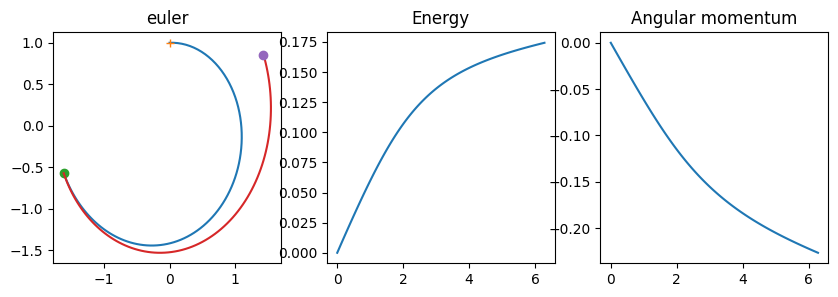

final location (x,y) = (-1.61902,-0.570571), time/2pi=1
final E+0.5=0.174225, max E+0.5=0.174225
After integrating backwards, (x,y,vx,vy) = (1.43643,0.858448,0.293318,-0.772712)


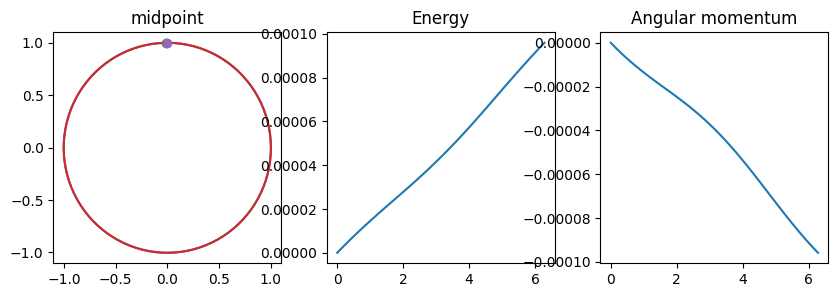

final location (x,y) = (-0.0151868,1.00007), time/2pi=1
final E+0.5=9.58669e-05, max E+0.5=9.58669e-05
After integrating backwards, (x,y,vx,vy) = (0.00179938,1.00037,0.999814,-0.00179569)


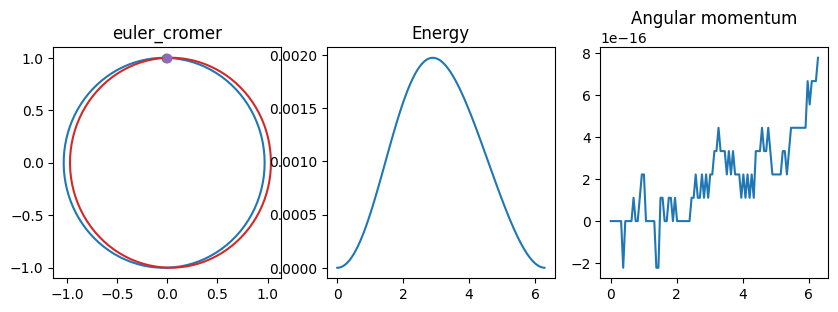

final location (x,y) = (-0.0175737,1.0002), time/2pi=1
final E+0.5=6.42988e-08, max E+0.5=0.00197581
After integrating backwards, (x,y,vx,vy) = (-4.56524e-05,1.00071,0.999288,4.13561e-05)


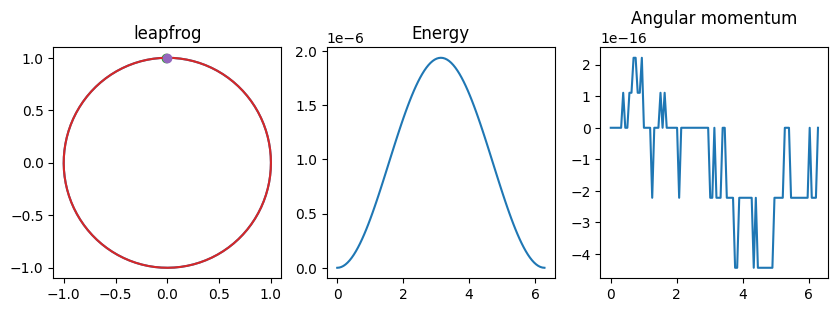

final location (x,y) = (-0.00825591,0.999966), time/2pi=1
final E+0.5=2.11164e-12, max E+0.5=1.93672e-06
After integrating backwards, (x,y,vx,vy) = (2.6229e-15,1,1,-2.20657e-15)


In [3]:
nsteps = 100   # number of steps per orbit
norbits = 1  # number of orbits to integrate

integrators = (euler, midpoint, euler_cromer, leapfrog)

for integrator in integrators:

    dt = 2*np.pi / nsteps
    t = np.arange(nsteps*norbits+1)*dt
    xx, yy, vx, vy = integrator(nsteps*norbits, dt, (0,1), (1,0))
    E = 0.5 * (vx**2 + vy**2) - 1/np.sqrt(xx**2 + yy**2)
    J = xx*vy - yy*vx

    fig = plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.plot(xx, yy)
    plt.plot(xx[0], yy[0], '+')
    plt.plot(xx[-1], yy[-1], 'o')
    plt.title(integrator.__name__)

    # now integrate back in time
    xx2, yy2, vx2, vy2 = integrator(nsteps*norbits, -dt, (xx[-1],yy[-1]), (vx[-1], vy[-1]))
    plt.plot(xx2, yy2)
    plt.plot(xx2[-1], yy2[-1], 'o')
    
    plt.subplot(132)
    plt.plot(t, E+0.5)
    plt.title('Energy')

    plt.subplot(133)
    plt.title('Angular momentum')
    plt.plot(t, J+1)

    plt.show()

    print('final location (x,y) = (%lg,%lg), time/2pi=%lg' % (xx[-1],yy[-1],t[-1]/(2*np.pi)))
    print('final E+0.5=%lg, max E+0.5=%lg' % (E[-1]+0.5,max(abs(E+0.5))))
    print('After integrating backwards, (x,y,vx,vy) = (%lg,%lg,%lg,%lg)' % (xx2[-1],yy2[-1],vx2[-1],vy2[-1]))




Calculating leapfrog
Calculating midpoint
Calculating euler_cromer
Calculating euler


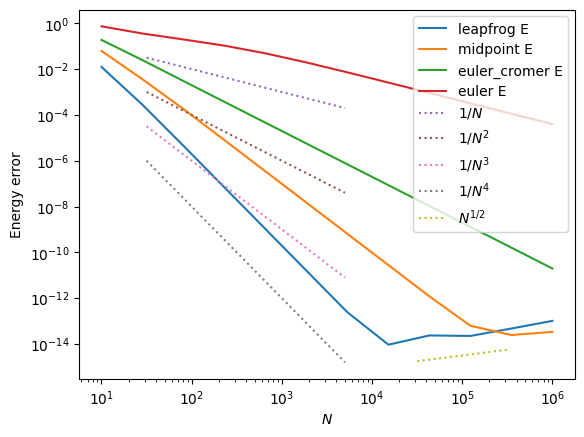

In [4]:
integrators = (euler, euler_cromer, midpoint, leapfrog)

for integrator in integrators[::-1]:
    
    print('Calculating %s' % (integrator.__name__,))
    
    n_vec = 10**np.linspace(1,6,12)
    E_vec = np.zeros_like(n_vec)
    x_vec = np.zeros_like(n_vec)

    for i, nsteps in enumerate(n_vec):
        dt = 2*np.pi / nsteps
        t = np.linspace(0, 2*np.pi, int(nsteps)+1)
        xx, yy, vx, vy = integrator(int(nsteps)+1, dt, (0,1), (1,0))
        E = 0.5 * (vx**2 + vy**2) - 1/np.sqrt(xx**2 + yy**2)
        #E_vec[i] = abs(E[-1]+0.5)
        E_vec[i] = max(abs(E+0.5))
        x_vec[i] = abs(np.sqrt(xx[-1]**2 + yy[-1]**2)-1)
        #print(n_vec[i], E_vec[i], x_vec[i])

    plt.plot(n_vec, E_vec, label = integrator.__name__+' E')
    #plt.plot(n_vec, x_vec, "--", label = integrator.__name__+ ' r')

n_vec = 10**np.linspace(1.5,3.7,10)
plt.plot(n_vec, 1/n_vec,":", label=r'$1/N$')
plt.plot(n_vec, 1/n_vec**2,":", label=r'$1/N^2$')
plt.plot(n_vec, 1/n_vec**3,":", label=r'$1/N^3$')
plt.plot(n_vec, 1/n_vec**4,":", label=r'$1/N^4$')
n_vec = 10**np.linspace(4.5,5.5,10)
plt.plot(n_vec, 1e-17*n_vec**0.5,":", label=r'$N^{1/2}$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$N$')
plt.ylabel(r'Energy error')
plt.legend()
plt.show()

## Simple harmonic motion

To investigate the properties of these integrators in more detail, consider a 1D simple harmonic oscillator (mass on a spring) where we can write the acceleration as $a_n = - x_n$. (Let's set the mass and spring constant to 1 for simplicity).

The Euler-Cromer update is then

$$v_{n+1} = v_n + h a_n = v_n - h x_n$$

$$x_{n+1} = x_n + h v_{n+1},$$

where we've also gone back to our previous notation and written the integration step as $h$ instead of $\Delta t$ (it's easier to write).

We can write this update as a matrix operation

$$\begin{pmatrix}x_{n+1} \\ v_{n+1}  \end{pmatrix} = 
\begin{pmatrix} 1 & h \\ 0 & 1 \end{pmatrix}
\begin{pmatrix} 1 & 0 \\ -h & 1 \end{pmatrix}\begin{pmatrix}x_n \\ v_n  \end{pmatrix}
=
\begin{pmatrix} 1-h^2 & h \\ -h & 1 \end{pmatrix} \begin{pmatrix}x_n \\ v_n  \end{pmatrix} = \mathbf{J} \cdot \begin{pmatrix}x_n \\ v_n  \end{pmatrix}$$

so that $\mathbf{J}$ is the matrix that takes the current $x$ and $v$ and updates them to the next timestep.  Another way to write this matrix is

$$\mathbf{J} = \begin{pmatrix} \partial x_{n+1}/\partial x_n & \partial x_{n+1}/\partial v_n \\ \partial v_{n+1}/\partial x_n & \partial v_{n+1}/\partial v_n \end{pmatrix},$$

i.e. it is the Jacobian associated with the transformation of variables $(x_n,v_n)\rightarrow (x_{n+1},v_{n+1})$. 

A **symplectic** integrator is one that preserves the phase space volume $dxdp$ ([Liouville's theorem](https://en.wikipedia.org/wiki/Liouville's_theorem_(Hamiltonian))), which implies that $\det \mathbf{J}=1$ (recall that when making a change of coordinates, the volume element [transforms](https://en.wikipedia.org/wiki/Volume_element) $dV\rightarrow (\det{J}) dV$).   We can see that the Jacobian for Euler-Cromer has this property.

In [5]:
# Check this using "SymPy" which does symbolic calculations
# you may need to 'pip install sympy'
import sympy.matrices
h = sympy.Symbol('h')
a = sympy.matrices.Matrix([[1,h],[0,1]])
b = sympy.matrices.Matrix([[1,0],[-h,1]])
J = a*b
print(J)
print('Determinant = ', J.det())

Matrix([[1 - h**2, h], [-h, 1]])
Determinant =  1


```{admonition} Exercise: symplectic integrators

(a) Calculate the Jacobian matrices for the Euler and Leapfrog methods. Calculate $\det\mathbf{J}$ in each case.

(b) Now use the Jacobians for the Euler, Euler-Cromer, and Leapfrog methods to determine whether these methods are time-reversible, i.e. if you take a step $h$ followed by a step $-h$, do you get back to where you started?

(c) Using the Jacobian and its transpose, calculate how the energy $E = (x^2 + v^2)/2$ changes when taking a step $h$. Obtain expressions for $E_{n+1}$ in terms of $x_n$ and $v_n$ for each method and discuss how you expect the energy error to scale with $h$ in each case.

Note: this is a symbolic rather than numerical exercise! You can use [SymPy](https://www.sympy.org/en/index.html) to help you with the matrix algebra. For example given a matrix `J` you can do `J.inv()` to get the symbolic expression for the inverse or `J.T` for the transpose. You can also use [`sympy.simplify`](https://docs.sympy.org/latest/modules/simplify/simplify.html) to simplify the answers.

[[Solution]](https://andrewcumming.github.io/phys512/symplectic_solutions.html#symplectic-integrators)

```

## Further reading

- An overview of symplectic integration with some interesting example applications is given by [Channell and Scovel 1990](https://ui.adsabs.harvard.edu/abs/1990Nonli...3..231C/abstract)
- The [REBOUND code](https://rebound.readthedocs.io/en/latest/) has implementation of many different symplectic integrators for orbital dynamics.